In [1]:
import pandas as pd
import numpy as np
import pprint as pp
import re, string
import time
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import praw
from datetime import datetime
from nltk.corpus import stopwords
from sklearn.feature_extraction import text 
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import math

# set seaborn settings
sns.set()
plt.rcParams["patch.force_edgecolor"] = True # set lines
plt.style.use('seaborn-darkgrid')


import warnings
warnings.filterwarnings('ignore')


import credentials as creds
import helpers as h

C:\Users\Jacky Zhao\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# https://praw.readthedocs.io/en/latest/getting_started/
# https://www.reddit.com/dev/api/

## Instantiate Reddit

In [3]:
CLIENT_ID = creds.client_id()
CLIENT_SECRET_KEY = creds.client_secret_key()


r = praw.Reddit(client_id = CLIENT_ID,
                client_secret = CLIENT_SECRET_KEY,
                user_agent = 'RedditorMatch')

print(r.read_only)

True


## Specify the scraped datasets

In [4]:
scraped_subreddits = ["mizzou", "umich"]

## Recommendation engine

In [5]:
def find_similar(matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(matrix[index: index + 1], matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

In [6]:
def getDf(subreddit_name):
    filePath = "data/" + subreddit_name + ".csv"
    df = pd.read_csv(filePath, encoding = "ISO-8859-1")
    print("--- Retrieved", len(df), "corpuses/corpi(?) for", subreddit_name)
    return(df)

In [7]:
def findMatches(your_username, subreddit_name, redditInstance):
    corpus = []    
    corpusDf = getDf(subreddit_name)
    corpusDf["Comments"].apply(lambda row: corpus.append(str(row)))
    
    your_comments = h.getUserComments(your_username, redditInstance)
    your_comments = ".".join(your_comments)
    
    corpus.insert(0, your_comments)
    
    print("--- Creating Tfidf vector...")
    
    myStopWords = stopwords.words('english')
    myStopWords = text.ENGLISH_STOP_WORDS.union(myStopWords)
    
    tf = TfidfVectorizer(analyzer = "word", 
                            ngram_range = (1, 3),
                            min_df = 0, 
                            stop_words = myStopWords)
    
    print("--- Fitting the matrix...")
    matrix = tf.fit_transform(corpus)
    results = []
    
    for index, score in find_similar(matrix, 0):        
        index = index - 1 # because we prepended our comments onto the corpus, the index number was shifted by 1.
        user = corpusDf.iloc[index, 0]
        results.append(user)
        print("...")
        print("...")
        print("Score:", score, "| Username:", user)
        print("=========================================================")
        
    return(results)

### Example:

In [8]:
matches = findMatches("Max_W_", scraped_subreddits[0], r)

--- Retrieved 288 corpuses/corpi(?) for mizzou
------ Retrieved 1877 comments for: Max_W_
--- Creating Tfidf vector...
--- Fitting the matrix...
...
...
Score: 0.996889562736 | Username: Max_W_
...
...
Score: 0.273236991224 | Username: SexyMcBeast
...
...
Score: 0.262435821781 | Username: KCTigerGrad
...
...
Score: 0.260764821456 | Username: PrancingPeach
...
...
Score: 0.260503797238 | Username: BrettGilpin


## Gather user information

In [9]:
def getRedditorInfo(redditor_name, r):
    user = r.redditor(redditor_name)
    top = user.comments.top(limit = 1000)
    hot = user.comments.hot(limit = 1000)
    contro = user.comments.controversial(limit = 1000)
    
    subreddit = []
    comment = []
    created_utc = []
    score = []
    ups = []
    downs = []
    controversiality = []
    flair = []
    gilded = []
    over_18 = []
    link = []
    
    for c in top:
        subreddit.append(c.subreddit_name_prefixed)
        comment.append(h.cleanText(c.body))
        
        parsed_date = datetime.utcfromtimestamp(c.created_utc)
        year = parsed_date.year
        month = parsed_date.month
        day = parsed_date.day
        
        created_utc.append(parsed_date)
        score.append(c.score)
        ups.append(c.ups)
        downs.append(c.downs)
        controversiality.append(c.controversiality)
        flair.append(c.author_flair_text)
        gilded.append(c.gilded)
        over_18.append(c.over_18)
        link.append(c.link_permalink)
        
    for c in hot:
        subreddit.append(c.subreddit_name_prefixed)
        comment.append(h.cleanText(c.body))
        
        parsed_date = datetime.utcfromtimestamp(c.created_utc)
        year = parsed_date.year
        month = parsed_date.month
        day = parsed_date.day
        
        created_utc.append(parsed_date)
        score.append(c.score)
        ups.append(c.ups)
        downs.append(c.downs)
        controversiality.append(c.controversiality)
        flair.append(c.author_flair_text)
        gilded.append(c.gilded)
        over_18.append(c.over_18)
        link.append(c.link_permalink)
        
    for c in contro:
        subreddit.append(c.subreddit_name_prefixed)
        comment.append(h.cleanText(c.body))
        
        parsed_date = datetime.utcfromtimestamp(c.created_utc)
        year = parsed_date.year
        month = parsed_date.month
        day = parsed_date.day
        
        created_utc.append(parsed_date)
        score.append(c.score)
        ups.append(c.ups)
        downs.append(c.downs)
        controversiality.append(c.controversiality)
        flair.append(c.author_flair_text)
        gilded.append(c.gilded)
        over_18.append(c.over_18)
        link.append(c.link_permalink)
        
    df = pd.DataFrame(subreddit, columns = ["subreddit"])
    df["comment"] = comment
    df["created_utc"] = created_utc
    df["score"] = score
    df["ups"] = ups
    df["downs"] = downs
    df["controversiality"] = controversiality
    df["flair"] = flair
    df["gilded"] = gilded
    df["over_18"] = over_18
    df["link"] = link
    
    df = df.drop_duplicates(subset = ["comment"], keep = "first")    
    print("Retrieved", len(df), "comments for user:", redditor_name)
    return(df)

### Examples

In [10]:
your_comments = getRedditorInfo("Max_W_", r)
other_comments = getRedditorInfo("PrancingPeach", r)

Retrieved 2425 comments for user: Max_W_
Retrieved 2734 comments for user: PrancingPeach


In [11]:
your_comments.head()

,subreddit,comment,created_utc,score,ups,downs,controversiality,flair,gilded,over_18,link
0,r/EnoughTrumpSpam,Can we start a petition to keep them private,2017-05-20 02:22:38,8572,8572,0,0,None,1,False,https://www.reddit.com/r/EnoughTrumpSpam/comme...
1,r/AskReddit,Two down one to go,2018-03-09 05:00:25,5550,5550,0,0,None,0,False,https://www.reddit.com/r/AskReddit/comments/83...
2,r/cringe,Lets applaud her dancers They continued on lik...,2017-01-01 05:24:43,3840,3840,0,0,None,0,False,https://www.reddit.com/r/cringe/comments/5ldm3...
3,r/AskReddit,What do you do when you come across an elephan...,2018-03-09 02:49:12,1967,1967,0,0,None,0,True,https://www.reddit.com/r/AskReddit/comments/83...
4,r/LivestreamFail,She threatened nuclear war with North Korea,2017-11-03 03:50:02,1753,1753,0,0,None,0,False,https://www.reddit.com/r/LivestreamFail/commen...


## Find common subreddits between 2 users

In [12]:
def commonSubreddits(user1, user2, redditInstance):
    
    df1 = getRedditorInfo(user1, redditInstance)
    df2 = getRedditorInfo(user2, redditInstance)
    
    df1 = df1.groupby(["subreddit"])[['comment']]\
                .count().reset_index()\
                .sort_values(["comment"], ascending = False)
            
    df2 = df2.groupby(["subreddit"])[['comment']]\
            .count().reset_index()\
            .sort_values(["comment"], ascending = False)
            
    df1 = df1.merge(df2, on = "subreddit", how = "inner")["subreddit"]
    result = np.array(df1)
    
    return(result)

In [13]:
def commonSubredditCounts(user1, user2, redditInstance):
    
    common = commonSubreddits(user1, user2, redditInstance)  
    
    df1 = getRedditorInfo(user1, redditInstance)
    df2 = getRedditorInfo(user2, redditInstance)
    
    df1 = df1[df1["subreddit"].isin(common)]
    df2 = df2[df2["subreddit"].isin(common)]
        
    df1Counts = df1.groupby(["subreddit"])[['comment']]\
                .count().reset_index()\
                .sort_values(["comment"], ascending = False)\
                .reset_index(drop = True)
                
    df2Counts = df2.groupby(["subreddit"])[['comment']]\
            .count().reset_index()\
            .sort_values(["comment"], ascending = False)\
            .reset_index(drop = True)              
                
    return(df1Counts, df2Counts)                              

### Examples

In [14]:
one, two = commonSubredditCounts("KCTigerGrad", "PrancingPeach", r)

Retrieved 983 comments for user: KCTigerGrad
Retrieved 2734 comments for user: PrancingPeach
Retrieved 983 comments for user: KCTigerGrad
Retrieved 2734 comments for user: PrancingPeach


In [15]:
one.head(10)

,subreddit,comment
0,r/mizzou,205
1,r/relationships,59
2,r/AskReddit,55
3,r/personalfinance,22
4,r/IAmA,21
5,r/jobs,16
6,r/politics,14
7,r/movies,5
8,r/explainlikeimfive,1
9,r/television,1


In [16]:
two.head(10)

,subreddit,comment
0,r/relationships,98
1,r/personalfinance,88
2,r/AskReddit,53
3,r/jobs,53
4,r/movies,46
5,r/politics,16
6,r/IAmA,10
7,r/television,7
8,r/mizzou,3
9,r/explainlikeimfive,1


## Get user flairs

In [17]:
def getFlairs(username, redditInstance):
    df = getRedditorInfo(username, redditInstance)
    flairs = set(np.unique(np.array((df[(df["flair"].isnull() == False) & (df["flair"] != "")]["flair"]))))
    if (len(flairs) < 1):
        print("No flairs for this user")
        return None
    else:
        return(flairs)

In [18]:
getFlairs("Max_W_", r)

Retrieved 2425 comments for user: Max_W_


{'Chiefs',
 'Honor 7X / Asus Nexus 7 / Moto e4+ ',
 'Honor 7X, Blue',
 'Kansas City Royals',
 'MaxW // Force Sensitive',
 'Missouri',
 'Nexus7 FHD',
 'Royals are clutch!'}

In [19]:
getFlairs("QiuYiDio", r)

Retrieved 2213 comments for user: QiuYiDio


{'Frequent Flyer', 'MBA Grad'}

## Classification of flairs

## Find top features

In [20]:
def top_tfidf_feats(row, features, top_n = 25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [21]:
def top_feats_in_doc(Xtr, features, row_id, top_n = 25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [22]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [23]:
def getTopFeatures(your_username, redditInstance):
    
    your_corpus = h.getUserComments(your_username, redditInstance)    
    
    myStopWords = stopwords.words('english')
    myStopWords = text.ENGLISH_STOP_WORDS.union(myStopWords)
    
    tf1 = TfidfVectorizer(analyzer = "word", 
                        ngram_range = (1, 3),
                        min_df = 0, 
                        stop_words = myStopWords)  
    
    matrix1 = tf1.fit_transform(your_corpus)
    features1 = tf1.get_feature_names()         
    yourTopOverallFeatures = top_mean_feats(matrix1, features1)
        
    return(yourTopOverallFeatures)

### Example

In [24]:
top = getTopFeatures("QiuYiDio", r)
top

------ Retrieved 1710 comments for: QiuYiDio


,feature,tfidf
0,read,0.006446
1,wiki,0.005452
2,https,0.004638
3,yes,0.004633
4,dont,0.003560
5,sticky,0.003333
6,op,0.003328
7,recruiting,0.003214
8,probably,0.003136
9,thread,0.002970


## Find subreddits that a user posts in

In [25]:
def getSubredditsPosted(username, redditInstance):
    comments = getRedditorInfo(username, redditInstance)
    subs = np.array(comments["subreddit"])
    subs = (np.unique(subs))
    return(subs)

In [26]:
getSubredditsPosted("Max_W_", r)

Retrieved 2425 comments for user: Max_W_


array(['r/ActLikeYouBelong', 'r/AdviceAnimals', 'r/AmIFreeToGo',
       'r/Android', 'r/AndroidQuestions', 'r/AnythingGoesPics', 'r/AskMen',
       'r/AskReddit', 'r/BacktotheFuture', 'r/Bad_Cop_No_Donut',
       'r/BannedFromThe_Donald', 'r/BeAmazed', 'r/Blackout2015',
       'r/BravesGIFs', 'r/BuyItForLife', 'r/C25K', 'r/CFB',
       'r/CatsStandingUp', 'r/Celebs', 'r/Chromecast', 'r/Cinemagraphs',
       'r/Cloververse', 'r/ColorizedHistory', 'r/Cyberpunk',
       'r/DC_Cinematic', 'r/DiWHY', 'r/EnoughTrumpSpam',
       'r/ExpectationVsReality', 'r/Eyeshakers', 'r/Fitness', 'r/Frugal',
       'r/Frugal_Jerk', 'r/Fullmoviesonvimeo', 'r/GalGadot',
       'r/GetMotivated', 'r/GradSchool', 'r/HadToHurt',
       'r/HighQualityGifs', 'r/Honor', 'r/Honor8', 'r/Huawei',
       'r/HumansBeingBros', 'r/IAmA', 'r/IDontWorkHereLady',
       'r/IdiotsFightingThings', 'r/IdiotsInCars',
       'r/ImGoingToHellForThis', 'r/Jokes', 'r/JusticePorn', 'r/KCRoyals',
       'r/KansasCityChiefs', 'r/LateS

## Analyze sentiment of user comments

In [27]:
def getSentiment(username, r):
    comments = getRedditorInfo(username, r)
                    
    if (len(comments) < 1):
        print("No comments for that user")
        return None
                        
    comments = comments.sort_values("created_utc", ascending = True)    
    sid = SentimentIntensityAnalyzer()
    
    comments["negative"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["neg"]) 
    comments["neutral"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["neu"]) 
    comments["positive"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["pos"]) 
    comments["compound"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["compound"]) 
    
    return(comments)    

### Examples

In [28]:
sents = getSentiment("Max_W_", r)
sents.head()

Retrieved 2425 comments for user: Max_W_


,subreddit,comment,created_utc,score,ups,downs,controversiality,flair,gilded,over_18,link,negative,neutral,positive,compound
2418,r/pics,Thats just his pay and doesnt include other bo...,2011-10-06 18:46:47,1,1,0,0,None,0,False,https://www.reddit.com/r/pics/comments/l39co/i...,0.199,0.801,0.000,-0.6894
66,r/AskReddit,I upvoted for karma but I think you already go...,2011-10-14 14:22:20,93,93,0,0,None,0,False,https://www.reddit.com/r/AskReddit/comments/lb...,0.000,1.000,0.000,0.0000
2417,r/pics,Thats odd suddenly at work I got a crick in my...,2011-10-19 18:13:18,1,1,0,0,None,0,False,https://www.reddit.com/r/pics/comments/lhpzc/w...,0.204,0.796,0.000,-0.3182
2416,r/AskReddit,Do yourself a favor and check out BAND OF BROT...,2011-10-24 19:37:39,1,1,0,0,None,0,False,https://www.reddit.com/r/AskReddit/comments/ln...,0.000,0.856,0.144,0.4019
2592,r/mizzou,Seems relevanthttp memegeneratornetcacheinstan...,2011-10-24 21:37:51,3,3,0,0,None,0,False,https://www.reddit.com/r/mizzou/comments/lnigs...,0.000,1.000,0.000,0.0000


## Plot sentiment of comments over time

In [29]:
def plotSentiment(username, subreddit_name, redditInstance):
    sents = getSentiment(username, redditInstance)
    subreddit_name = "r/" + subreddit_name
    sents = sents[sents["subreddit"].str.lower() == subreddit_name.lower()]
    sents = sents.sort_values("created_utc", ascending = True)  
    sents = sents.reset_index()
    sents["id"] = sents.index
    
    if (len(sents) < 3):
        print("User has not posted on this subreddit")
        return        
        
    _ = plt.plot(sents["id"], sents["compound"], marker = "", linewidth = 1.9, alpha = 0.9)
    title = "Sentiment analysis on " + subreddit_name + " for user: " + username
    _ = plt.suptitle(title)
    _ = plt.show()
    
    return

In [30]:
def plotTopSentiments(username, redditInstance):
    sents = getSentiment(username, redditInstance)    
   
    subreddits = np.array(sents.groupby(["subreddit"]).\
                                                  count().\
                                                  reset_index().\
                                                  sort_values("comment", ascending = False).\
                                                  head(4)["subreddit"])
    
    numberOfSubs = len(subreddits)
    
    # create a color palette
    palette = plt.get_cmap('Set1')
    num = 0
    
    for s in subreddits:       
        
        subreddit_name = s
        df = sents[sents["subreddit"].str.lower() == subreddit_name.lower()]       
        
        if (len(df) >= 2):            
            num = num + 1 

            # Find the right spot on the plot
            _ = plt.subplot(2, 2, num)                 

            df = df.sort_values("created_utc", ascending = True)  
            df = df.reset_index()
            df["id"] = df.index

            _ = plt.plot(df["id"], df["compound"], marker = "", linewidth = 1.9, alpha = 0.9, color = palette(num))

            # Not ticks everywhere
            if num in range(7) :
                _ = plt.tick_params(labelbottom='off')
            if num not in [1,4,7] :
                _ = plt.tick_params(labelleft='off')

            # Add title
            _ = plt.title(subreddit_name, loc='left', fontsize=12, fontweight=0, color=palette(num))
             

    title = "Sentiment analysis " + "for user: " + username
    _ = plt.suptitle(title, fontsize=13, fontweight=0, color='black', style='italic', y=1.02)    
    _ = plt.show()
    
    return

### Examples

Retrieved 2425 comments for user: Max_W_


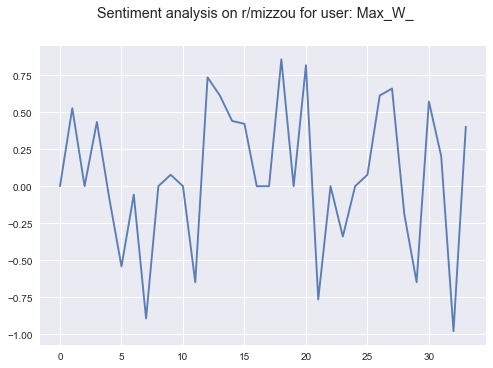

In [31]:
plotSentiment("Max_W_", "mizzou", r)

Retrieved 2425 comments for user: Max_W_


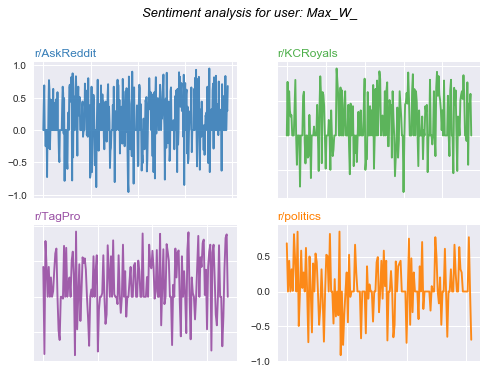

In [32]:
plotTopSentiments("Max_W_", r)

In [33]:
# why makes a comment get a lot of upvotes?